## Demo of Probabilistic Tensor Decomposition of Neural Population Spiking Activity

### Preamble

In this notebook, we illustrate the probabilistic decomposition of a partially observed rank 4 count tensor (of size <small> $100 \times 70 \times 3 \times 4 \times 5$ </small>) defined by


  

$ (\mathcal{X} | \mathcal{W}, \mathcal{V}, \zeta) \sim \text{Negative Binomial}(\zeta, p),$

where

- $\mathcal{W} = [|A^{(1)}, ..., A^{(5)}|]$ is a low rank tensor whose Canonical Polyadic (CP) decomposition we are looking for.

- $\mathcal{V}$ is a tensor constrained to vary only across the first and third dimension

- $\zeta$ is a shape parameter

- $p =  \frac{1}{ 1+e^{\mathcal{W}+ \mathcal{V}} }.$

In addition, we assume that we dispose of three "neurons" groups defined such that $A^{(1)}$ is a block sparse matrix.


### Generate toy dataset

Text(0.5, 0.98, 'True Factors W = [|A1, .., A5|]')

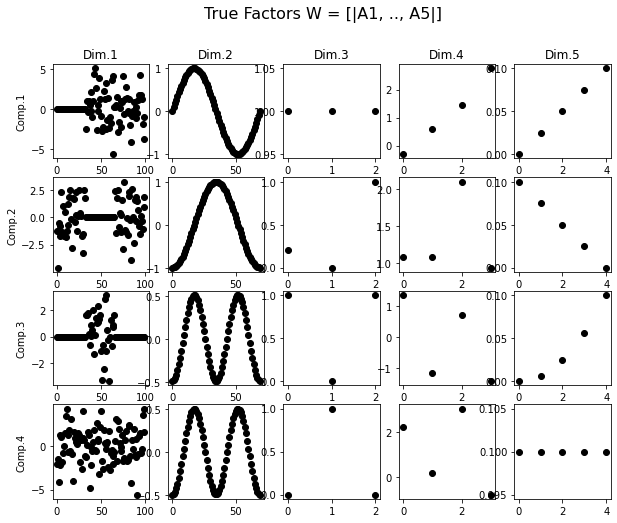

In [6]:
# Imports and random seeds
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'..')
from vbgcp.vb_gcp import VBGCPTensor
from vbgcp.components import FitParams
from examples.toydata import build_toydaset
from vbgcp.utils import (plot_factors, expand_factors, get_similarity, reorder_models)
np.random.seed(1)


# Build toy data set with an offset
params = build_toydaset(add_offset=1)

# Factors W = [|A1,.., A5|]
factors_true = params['factors']

# Constrained Offset V
offset_true = params['offset']
offset_dim = params['offset_dim']

# Observed counts X
observed_tensor = params['observed_tensor']

# Neuron Groups
neuron_groups = params['neurons_groups']
shared_precision_mode = 0

# Observe only ~ 50% of the full tensor
observed_data = np.random.rand(*observed_tensor.shape) > 0.5
observed_tensor = observed_tensor * observed_data

# Plot true factors
fig = plt.figure(figsize=(10,8))
plot_factors(factors_true)
fig.suptitle('True Factors W = [|A1, .., A5|]', fontsize=16)



### Probabilistic Tensor Decomposition: Fit

In [ ]:
# Putative tensor rank
tensor_rank = 6

# Run variational inference
fit_params = FitParams(observed_tensor.shape, tensor_rank,
                       observed_data=observed_data, fit_offset_dim=offset_dim,
                       shared_precision_dim=offset_dim, shared_precision_mode=shared_precision_mode,
                       neuron_groups=neuron_groups, ite_max=4000, disppct=400)

vbgcp = VBGCPTensor(observed_tensor.shape, tensor_rank, shape_param=120, fit_params=fit_params)
vbgcp.variational_inference(observed_tensor)

Iterations: 0000 / 4000 | loss =   -69543546.0405 | shape =   119.7342
Iterations: 0400 / 4000 | loss =   -69670793.1210 | shape =   108.1928
Iterations: 0800 / 4000 | loss =   -69671926.5806 | shape =   99.5782
Iterations: 1200 / 4000 | loss =   -69673065.2284 | shape =   93.1709
Iterations: 1600 / 4000 | loss =   -69673639.6021 | shape =   88.6919
Iterations: 2000 / 4000 | loss =   -69673734.5204 | shape =   85.6620
Iterations: 2400 / 4000 | loss =   -69673783.4795 | shape =   83.6791


### Probabilistic Tensor Decomposition: Plot Results

In [ ]:
models = [expand_factors(factors_true, 6), vbgcp.posteriors.factors_mean]
smlty, _,_ = get_similarity(models)
print(smlty)
models = reorder_models(models)


plt.figure()
plot_factors(models[0])
plot_factors(models[1], color='m')

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(vbgcp.shape_param_tot, color='k')
plt.plot(np.ones(len(vbgcp.shape_param_tot))*params['model']['shape'], color='m')

plt.title('Shape Param')
plt.xlabel('Iterations')

plt.subplot(1, 2, 2)
plt.plot(vbgcp.loss_tot, color='k')
plt.xlabel('Iterations')
plt.title('Loss')

plt.figure()
plot_factors(vbgcp.posteriors.factors_mean)

plt.figure()
plot_factors(params['factors'])

# TODO: check offset + add similarity + check initialization + plot and normalize cariance, check missing data
# TODO: when checking offset, also chek init of the offset
# TODO: add disppct

In [ ]:
# TODO also reorder the variance ?
# TODO: add a checker for size and rank. reorder and normalize cp. Then use first CPs if rank different from ref
# TODO: check that normalise cp with Normdim works !






